# **Blocks classification**

### **Dataset**
https://archive.ics.uci.edu/ml/datasets/Page+Blocks+Classification

The problem consists of classifying all the blocks of the page layout of a document that has been detected by a segmentation process. This is an essential step in document analysis in order to separate text from graphic areas. Indeed, the five classes are: text (1), horizontal line (2), picture (3), vertical line (4) and graphic (5).

### **Source**

> Original Owner

Donato Malerba
Dipartimento di Informatica
University of Bari
via Orabona 4
70126 Bari - Italy
phone: +39 - 80 - 5443269
fax: +39 - 80 - 5443196
malerbad '@' vm.csata.it

> Donor

Donato Malerba

### **Data Set Information**

The 5473 examples comes from 54 distinct documents. Each observation concerns one block. All attributes are numeric. Data are in a format readable by C4.5.
Missing Attribute Values:  No missing value.

### **Attribute Information**

height: integer. | Height of the block;

lenght: integer. | Length of the block;

area: integer. | Area of the block (height * lenght);

eccen: continuous. | Eccentricity of the block (lenght / height);

p_black: continuous. | Percentage of black pixels within the block (blackpix / area);

p_and: continuous. | Percentage of black pixels after the application of the Run Length Smoothing Algorithm (RLSA) (blackand / area);

mean_tr: continuous. | Mean number of white-black transitions (blackpix / wb_trans);

blackpix: integer. | Total number of black pixels in the original bitmap of the block;

blackand: integer. | Total number of black pixels in the bitmap of the block after the RLSA;

wb_trans: integer. | Number of white-black transitions in the original bitmap of the block;

prediction: integer. | Block classes : text (1), horizontal line (2), picture (3), vertical line (4) and graphic (5).




## **Libraries import**

In [23]:
# Data visualizayion use
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ML use
# Any results you write to the current directory are saved as output.
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
import xgboost as xgb
from xgboost import XGBClassifier
from collections import Counter
import time
from sklearn import metrics
from sklearn.model_selection import KFold

## **Dataset read**

In [24]:
# Reading the csv document. Previously added attribute names for each column. 
data = pd.read_csv("page-blocks.csv",sep=";")
data

,height,length,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans,prediction
0,5,7,35,1.400,0.400,0.657,2.33,14,23,6,1
1,6,7,42,1.167,0.429,0.881,3.60,18,37,5,1
2,6,18,108,3.000,0.287,0.741,4.43,31,80,7,1
3,5,7,35,1.400,0.371,0.743,4.33,13,26,3,1
4,6,3,18,0.500,0.500,0.944,2.25,9,17,4,1
...,...,...,...,...,...,...,...,...,...,...,...
5468,4,524,2096,131.000,0.542,0.603,40.57,1136,1264,28,2
5469,7,4,28,0.571,0.714,0.929,10.00,20,26,2,1
5470,6,95,570,15.833,0.300,0.911,1.64,171,519,104,1
5471,7,41,287,5.857,0.213,0.801,1.36,61,230,45,1


# **Dataset checks**

In [25]:
# Checking the number of values 
data.count()

height        5473
length        5473
area          5473
eccen         5473
p_black       5473
p_and         5473
mean_tr       5473
blackpix      5473
blackand      5473
wb_trans      5473
prediction    5473
dtype: int64

In [26]:
# Checking line and columns
nb_lignes, nb_col = data.shape
print(nb_lignes)
print(nb_col)

5473
11


In [27]:
# Checking the name of the columns added before reading the csv
data.columns

Index(['height', 'length', 'area', 'eccen', 'p_black', 'p_and', 'mean_tr',
       'blackpix', 'blackand', 'wb_trans', 'prediction'],
      dtype='object')

In [28]:
# Checking the column type
data.dtypes

height          int64
length          int64
area            int64
eccen         float64
p_black       float64
p_and         float64
mean_tr       float64
blackpix        int64
blackand        int64
wb_trans        int64
prediction      int64
dtype: object

In [29]:
# "No missing values" said in the dataset description, let's check it
data.isnull().sum()

height        0
length        0
area          0
eccen         0
p_black       0
p_and         0
mean_tr       0
blackpix      0
blackand      0
wb_trans      0
prediction    0
dtype: int64

In [30]:
data.isna().sum()

height        0
length        0
area          0
eccen         0
p_black       0
p_and         0
mean_tr       0
blackpix      0
blackand      0
wb_trans      0
prediction    0
dtype: int64

In [31]:
# Finally, let's describe the dataset 
data.describe()

,height,length,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans,prediction
count,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000
mean,10.473232,89.568244,1198.405628,13.753977,0.368642,0.785053,6.219278,365.930751,741.108167,106.662891,1.202631
std,18.960564,114.721758,4849.376950,30.703737,0.177757,0.170661,69.079021,1270.333082,1881.504302,167.308362,0.721470
min,1.000000,1.000000,7.000000,0.007000,0.052000,0.062000,1.000000,7.000000,7.000000,1.000000,1.000000
25%,7.000000,17.000000,114.000000,2.143000,0.261000,0.679000,1.610000,42.000000,95.000000,17.000000,1.000000
50%,8.000000,41.000000,322.000000,5.167000,0.337000,0.803000,2.070000,108.000000,250.000000,49.000000,1.000000
75%,10.000000,107.000000,980.000000,13.625000,0.426000,0.927000,3.000000,284.000000,718.000000,126.000000,1.000000
max,804.000000,553.000000,143993.000000,537.000000,1.000000,1.000000,4955.000000,33017.000000,46133.000000,3212.000000,5.000000


In [33]:
columns = ('text', 'horizontal line', 'picture', 'vertical line', 'graphic')
data.prediction.replace((1, 2, 3, 4, 5), columns, inplace=True)
data.sample(10)

,height,length,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans,prediction
4289,23,124,2852,5.391,0.941,1.000,17.21,2684,2852,156,text
494,10,38,380,3.800,0.432,0.939,2.78,164,357,59,text
1703,7,11,77,1.571,0.351,0.922,1.59,27,71,17,text
372,10,80,800,8.000,0.314,0.799,2.06,251,639,122,text
634,8,71,568,8.875,0.329,0.776,1.83,187,441,102,text
1498,804,11,8844,0.014,0.191,0.233,15.64,1689,2058,108,vertical line
1685,5,14,70,2.800,0.414,0.943,1.38,29,66,21,text
3489,7,12,84,1.714,0.226,0.786,1.90,19,66,10,text
5284,8,302,2416,37.750,0.211,0.730,1.43,510,1763,356,text
4419,25,169,4225,6.760,0.218,0.971,1.58,923,4101,586,text


## **Data visualization**

### Distribution of each predicted class

In [34]:
data.prediction.value_counts()

text               4913
horizontal line     329
graphic             115
vertical line        88
picture              28
Name: prediction, dtype: int64

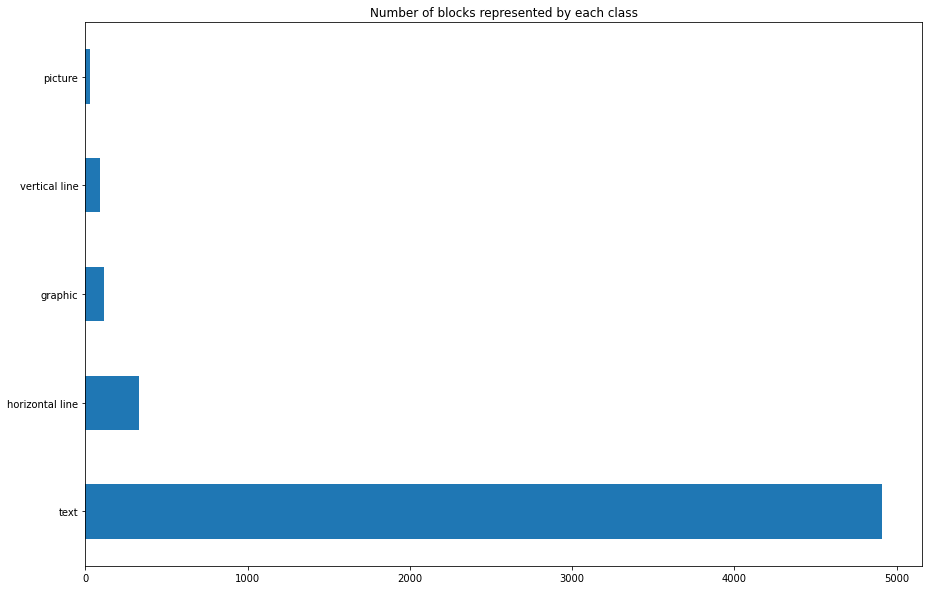

In [35]:
data.prediction.value_counts().plot.barh(title="Number of blocks represented by each class", figsize=(15,10))

In [36]:
p_prediction = ((data.prediction.value_counts()) / data.prediction.count()) * 100
p_prediction

text               89.767952
horizontal line     6.011328
graphic             2.101224
vertical line       1.607893
picture             0.511602
Name: prediction, dtype: float64

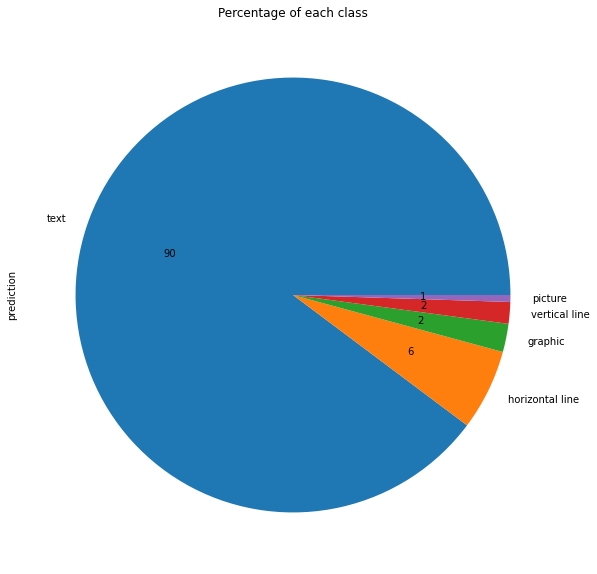

In [37]:
p_prediction.plot.pie(figsize=(15, 10), autopct="%.f", title="Percentage of each class");

90% of the blocks are texts

## Relationship between area and classes type

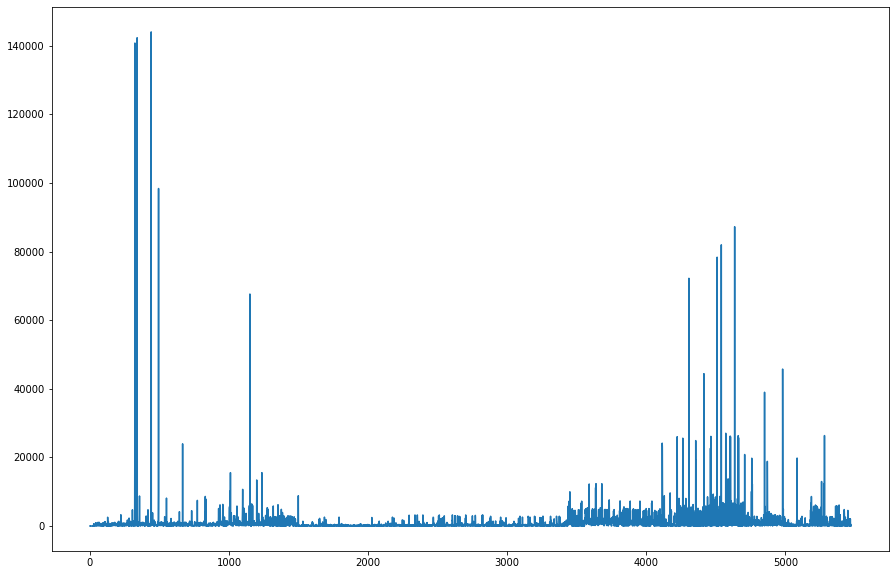

In [38]:
data.area.plot(figsize=(15,10))

In [39]:
number = data.loc[data.area <= 10000].count()
number

height        5418
length        5418
area          5418
eccen         5418
p_black       5418
p_and         5418
mean_tr       5418
blackpix      5418
blackand      5418
wb_trans      5418
prediction    5418
dtype: int64

In [40]:
ratio = number/data.count()*100
ratio

height        98.995067
length        98.995067
area          98.995067
eccen         98.995067
p_black       98.995067
p_and         98.995067
mean_tr       98.995067
blackpix      98.995067
blackand      98.995067
wb_trans      98.995067
prediction    98.995067
dtype: float64

99% of the blocks have an area content lower than 10000.

In [41]:
data.groupby("prediction").mean()

,height,length,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans
prediction,,,,,,,,,,
graphic,43.660870,89.965217,9513.782609,2.064878,0.182183,0.444061,6.681130,1250.626087,2435.539130,210.895652
horizontal line,2.544073,141.875380,509.303951,79.442830,0.669207,0.836845,46.629088,279.805471,324.404255,12.826748
picture,100.535714,153.071429,21448.035714,1.401571,0.498250,0.670607,33.368214,9876.142857,13185.750000,666.071429
text,9.132302,87.255038,951.303888,9.937869,0.343385,0.788392,3.028687,302.253002,670.416853,109.090169
vertical line,42.954545,2.431818,260.534091,0.424648,0.857500,0.887000,24.029091,60.909091,71.704545,7.761364


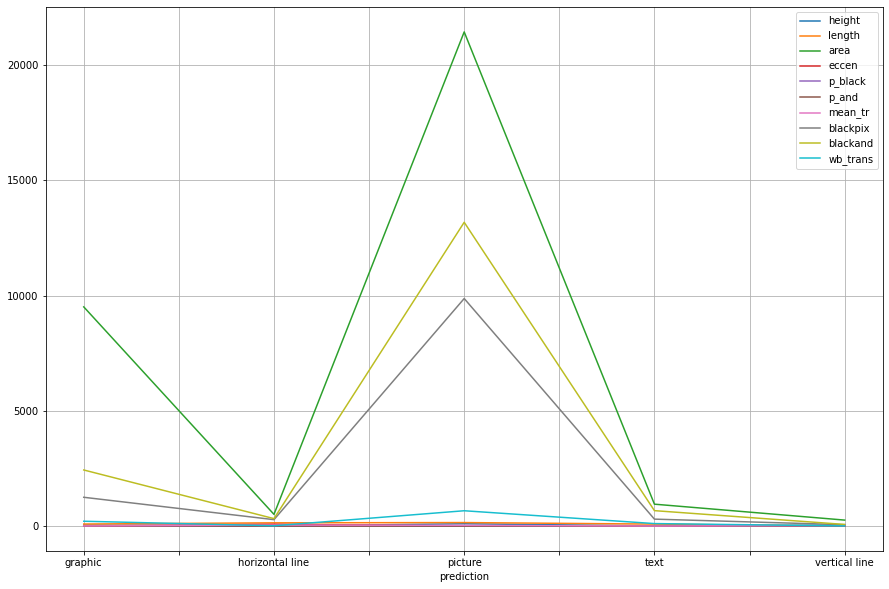

In [42]:
data.groupby("prediction").mean().plot(figsize=(15,10), grid=True)

We can see on this graph that the blocks taking the most space (L*H area) are  the pictures and graphics (green curve).

The second interesting point is that pictures have the higher total number of black pixels in the original bitmap of the block. We can see a correlation between the number of pixels and the place taken by the block.

## Correlation between all attributes

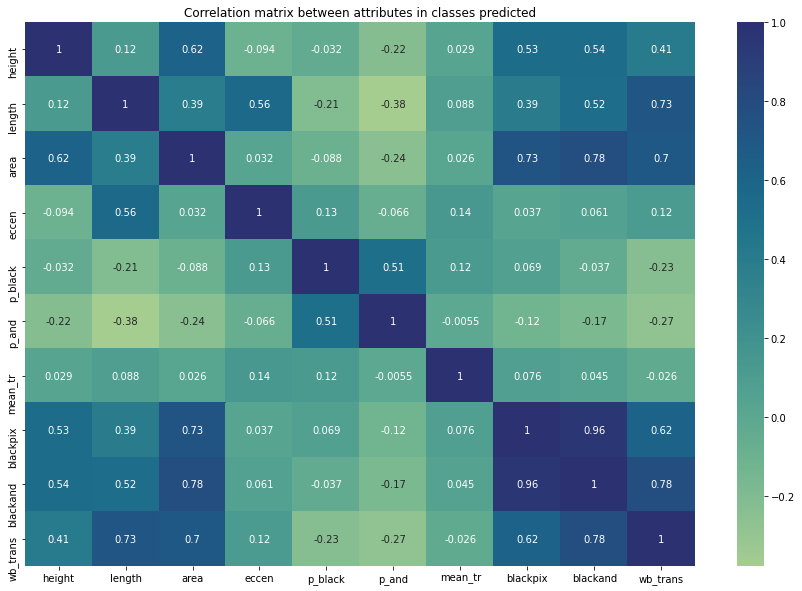

In [43]:
plt.figure(figsize=(15,10))
plt.title('Correlation matrix between attributes in classes predicted')
sns.heatmap(data=data.corr(), annot=True, cmap="crest")
plt.show()

**The highest correlation is between the blackpic and blackand attributes.** These attributes represent the total number of black pixels in the original bitmap of the block and the total number of black pixels in the bitmap of the block after the RLSA. 

This correlation is logical given the behaviour of the algorithm. 

The basic RLSA is applied to a binary sequence in which white pixels are represented by 0’s and black pixels by 1’s. The algorithm transforms a binary sequence x into an output sequence y according to the following rules :

1. 0’s in x are changed to 1’s in y if the number of adjacent 0’s is less than or equal to a predefined limit C.
2. 1’s in x are unchanged in y .

**The second highest correlation is between wb_trans and blackand attributes.** These attributes represent the number of white-black transitions in the original bitmap of the block and the total number of black pixels in the bitmap of the block after the RLSA. This correlation is also logical given the behaviour of the algorithm described below. 

**The third correlation is between blackand et area attributes.** These attributes represent the total number of black pixels in the bitmap of the block after the RLSA and the area of the block (height * lenght). This is a positive correlation. The more black pixels there are after the algorithm RLSA, the larger the area taken is.

# **Data modeling**

## Seperating data for test and train
####Our Data Set is pretty small, so 85% is going to be for training and 15% for testing

In [ ]:
x_data, y_data = data.drop("prediction", axis=1), data.prediction

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=0)

###1) **BaseLine**
We've tested 4 differents model with basic input

In [ ]:
#XGBClassifier
alg = XGBClassifier()
alg.fit(x_train, y_train, eval_metric='auc')
predictionsXGBClassifier = alg.predict(x_test)

#MLPClassifier
clf = MLPClassifier()
clf.fit(x_train, y_train)
predictionsMLPClassifier = clf.predict(x_test)

#RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
predictionsRandomForestClassifier = clf.predict(x_test)  

#LogisticRegression
clf = LogisticRegression()
clf.fit(x_train, y_train)
predictionLogisticRegression = clf.predict(x_test)

print('The accuracy of the XGBClassifier is', round(metrics.accuracy_score(predictionsXGBClassifier,y_test), 4))
print('The accuracy of the MLPClassifier is', round(metrics.accuracy_score(predictionsMLPClassifier,y_test), 4))
print('The accuracy of the ForestClassifier is', round(metrics.accuracy_score(predictionsRandomForestClassifier,y_test), 4))
print('The accuracy of the LogisticRegression is', round(metrics.accuracy_score(predictionLogisticRegression,y_test), 4))

The accuracy of the XGBClassifier is 0.9769
The accuracy of the MLPClassifier is 0.9525
The accuracy of the ForestClassifier is 0.972
The accuracy of the LogisticRegression is 0.9452


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


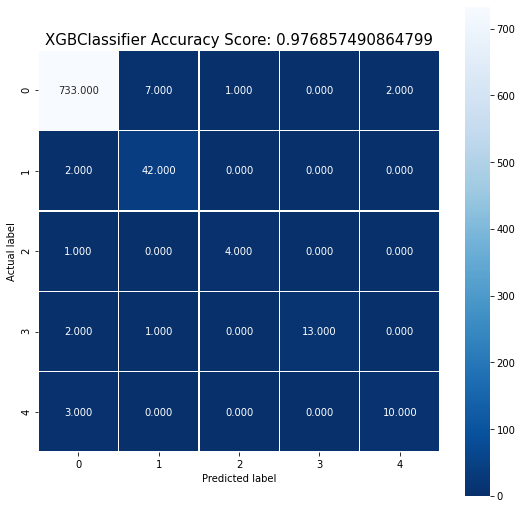

In [ ]:
cm = metrics.confusion_matrix(y_test, predictionsXGBClassifier)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'XGBClassifier Accuracy Score: {0}'.format(alg.score(x_test,y_test))
plt.title(all_sample_title, size = 15);

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18


### 2) **Preprocessing**

Our data is imbalanced, Text class is 90% of all the data, and some of the class like graphic is 0.5 (28 over 5473). we need to have more balanced data in order to improve our model.

to deal with this imbalanced we have to have the same amount of data for each class. We can either duplicate data to have the same amount as the most one, or cut data to have the same amount as the lower one.

In this problem, the amount of data of our smallest one is so low that our model would be underFit (we only have 28 data for our lowest one)

We choosed to duplicate data for our largest class.

!!ATTENTION!! only duplicate data on your train and not test. 

In [ ]:
from sklearn.utils import resample

X = pd.concat([x_train, y_train], axis=1)
text = X[X.prediction==1]
HorizontalLigne = X[X.prediction==2]
picture = X[X.prediction==3]
VerticaleLigne = X[X.prediction==4]
Graphic = X[X.prediction==5]

HorizontalLigne_upsampled = resample(HorizontalLigne,
                          replace=True,
                          n_samples=len(text), # match number in majority class
                          random_state=27) # reproducible results
picture_upsampled = resample(picture,
                          replace=True, # sample with replacement
                          n_samples=len(text), # match number in majority class
                          random_state=27) # reproducible results
VerticaleLigne_upsampled = resample(VerticaleLigne,
                          replace=True, # sample with replacement
                          n_samples=len(text), # match number in majority class
                          random_state=27) # reproducible results
Graphic_upsampled = resample(Graphic,
                          replace=True, # sample with replacement
                          n_samples=len(text), # match number in majority class
                          random_state=27) # reproducible results
upsampled = pd.concat([text, HorizontalLigne_upsampled,picture_upsampled,VerticaleLigne_upsampled,Graphic_upsampled])
x_train_upsamble, y_data_upsamble = data.drop("prediction", axis=1), data.prediction
upsampled.prediction.value_counts()

5    4170
4    4170
3    4170
2    4170
1    4170
Name: prediction, dtype: int64

In [ ]:
#XGBClassifier
alg = XGBClassifier()
alg.fit(x_train_upsamble, y_data_upsamble, eval_metric='auc')
predictionsXGBClassifierPostProcessing = alg.predict(x_test)

#MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100,))
clf.fit(x_train_upsamble, y_data_upsamble)
predictionsMLPClassifierPostProcessing = clf.predict(x_test)

#RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(x_train_upsamble, y_data_upsamble)
predictionsRandomForestClassifierPostProcessing = clf.predict(x_test)  

#LogisticRegression
clf = LogisticRegression()
clf.fit(x_train_upsamble, y_data_upsamble)
predictionLogisticRegressionPostProcessing = clf.predict(x_test)

print('The accuracy of the XGBClassifierPostProcessing is', round(metrics.accuracy_score(predictionsXGBClassifierPostProcessing,y_test), 4))
print('The accuracy of the MLPClassifierPostProcessing is', round(metrics.accuracy_score(predictionsMLPClassifierPostProcessing,y_test), 4))
print('The accuracy of the ForestClassifierPostProcessing is', round(metrics.accuracy_score(predictionsRandomForestClassifierPostProcessing,y_test), 4))
print('The accuracy of the LogisticRegressionPostProcessing is', round(metrics.accuracy_score(predictionLogisticRegressionPostProcessing,y_test), 4))

The accuracy of the XGBClassifierPostProcessing is 0.9915
The accuracy of the MLPClassifierPostProcessing is 0.9586
The accuracy of the ForestClassifierPostProcessing is 0.9988
The accuracy of the LogisticRegressionPostProcessing is 0.9574


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


without changing any hyperParameters, by just Preprocessing our data, we improved ForestClassifier from 0.9756 tp 0.9988 and XGBClassifier from 0. 9769 to 0.9915 

###3) **Hyperparameters**

our Data is so small that hyperParameters will not improve much the accuracy of our model, only the max_depth and n_estimators will changed something significantly \n

we are only going to improve RandomForest and XGBClassifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
clf = xgb.XGBClassifier()

param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20, 25],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [500]}

fit_param = {'eval_metric': 'accuracy',
              'early_stopping_rounds': 10,
              'eval_set': [(x_train_upsamble, y_data_upsamble)]}

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=50,
                            n_jobs=1, verbose=2, cv=2,
                            scoring='accuracy', refit=True, random_state=42)

rs_clf.fit(x_train_upsamble, y_data_upsamble)
best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] subsample=0.7, silent=False, reg_lambda=50.0, n_estimators=500, min_child_weight=5.0, max_depth=25, learning_rate=0, gamma=0.5, colsample_bytree=0.8, colsample_bylevel=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.7, silent=False, reg_lambda=50.0, n_estimators=500, min_child_weight=5.0, max_depth=25, learning_rate=0, gamma=0.5, colsample_bytree=0.8, colsample_bylevel=0.4, total=   2.7s
[CV] subsample=0.7, silent=False, reg_lambda=50.0, n_estimators=500, min_child_weight=5.0, max_depth=25, learning_rate=0, gamma=0.5, colsample_bytree=0.8, colsample_bylevel=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  subsample=0.7, silent=False, reg_lambda=50.0, n_estimators=500, min_child_weight=5.0, max_depth=25, learning_rate=0, gamma=0.5, colsample_bytree=0.8, colsample_bylevel=0.4, total=   2.6s
[CV] subsample=0.6, silent=False, reg_lambda=1.0, n_estimators=500, min_child_weight=1.0, max_depth=15, learning_rate=0.2, gamma=1.0, colsample_bytree=0.8, colsample_bylevel=0.7 
[CV]  subsample=0.6, silent=False, reg_lambda=1.0, n_estimators=500, min_child_weight=1.0, max_depth=15, learning_rate=0.2, gamma=1.0, colsample_bytree=0.8, colsample_bylevel=0.7, total=   4.4s
[CV] subsample=0.6, silent=False, reg_lambda=1.0, n_estimators=500, min_child_weight=1.0, max_depth=15, learning_rate=0.2, gamma=1.0, colsample_bytree=0.8, colsample_bylevel=0.7 
[CV]  subsample=0.6, silent=False, reg_lambda=1.0, n_estimators=500, min_child_weight=1.0, max_depth=15, learning_rate=0.2, gamma=1.0, colsample_bytree=0.8, colsample_bylevel=0.7, total=   4.0s
[CV] subsample=0.9, silent=False, reg_lambda=50.0, n_estimato

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.1min finished


Best score: 0.9629079892826696
Best params: 
colsample_bylevel: 0.4
colsample_bytree: 0.5
gamma: 0.5
learning_rate: 0.1
max_depth: 6
min_child_weight: 1.0
n_estimators: 500
reg_lambda: 5.0
silent: False
subsample: 0.7


In [ ]:
param_grid_random={
    "max_depth" : np.arange(1, 10, 1),
    'n_estimators': np.arange(200, 700, 100),
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}
grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid_random,
    scoring="accuracy",
    cv=KFold(5, shuffle=True)
)

grid.fit(x_train_upsamble, y_data_upsamble)

grid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
modelRandomForest = RandomForestClassifier(max_depth=30, n_estimators=500)
modelRandomForest.fit(x_train_upsamble,y_data_upsamble)
predictionRFC=modelRandomForest.predict(x_test)

alg = XGBClassifier(learning_rate=0.1, n_estimators=500, max_depth=30,
                      min_child_weight=1, gamma=0.5, subsample=0.7, colsample_bytree=0.5, colsample_bylevel= 0.4,
                      objective='binary:logistic', nthread=4, scale_pos_weight=5, seed=27)


alg.fit(x_train_upsamble, y_data_upsamble, eval_metric='auc')
predictionXGBC = alg.predict(x_test)

print('The accuracy of the XGBClassifier is', round(metrics.accuracy_score(predictionXGBC,y_test), 4))
print('The accuracy of the Random Forest is', round(metrics.accuracy_score(predictionRFC,y_test), 5))

The accuracy of the XGBClassifier is 0.9976
The accuracy of the Random Forest is 1.0


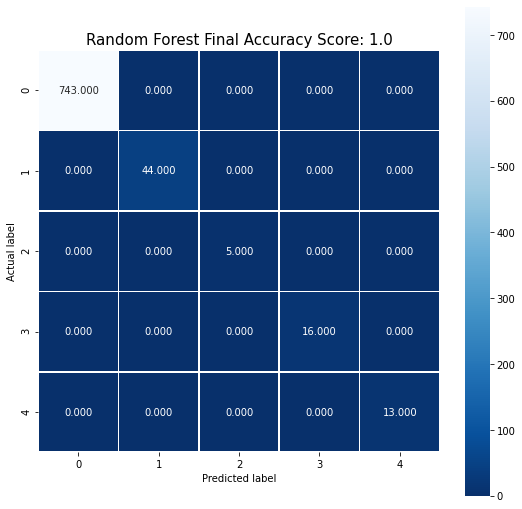

In [ ]:
cm = metrics.confusion_matrix(y_test, predictionRFC)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.6, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Random Forest Final Accuracy Score: {0}'.format(modelRandomForest.score(x_test,y_test))
plt.title(all_sample_title, size = 15);

###4) **Choosing model**
both model have almost the same accuracy, we are going to take the fastest one

In [ ]:
import timeit

startRandomForest = timeit.default_timer()
predictionRFCTest = modelRandomForest.predict(x_data)
stopstartRandomForest = timeit.default_timer()

startXGB = timeit.default_timer()
predictionXGBCTest = alg.predict(x_data)
stopXGB = timeit.default_timer()

print('The accuracy of the XGBClassifier is', round(metrics.accuracy_score(predictionXGBCTest,y_data), 4))
print('The accuracy of the Random Forest is', round(metrics.accuracy_score(predictionRFCTest,y_data), 5))

timeXGBC = stopXGB - startXGB
timeRandomForest = stopstartRandomForest - startRandomForest
print('Time: RandomForest', timeRandomForest) 
print('Time: predictionXGBC', timeXGBC)  

print(timeRandomForest/timeXGBC)

The accuracy of the XGBClassifier is 0.9965
The accuracy of the Random Forest is 0.99744
Time: RandomForest 0.3410056469997471
Time: predictionXGBC 0.3393937159999041
1.0047494426792614


In [ ]:
Result = {'XGBClassifier': [alg.score(x_test,y_test),timeXGBC], 'Random Forest': [modelRandomForest.score(x_test,y_test),timeRandomForest]}
df = pd.DataFrame(data=Result).rename(index={0: "Accuracy", 1:"Time"})
df



,XGBClassifier,Random Forest
Accuracy,0.997564,1.000000
Time,0.339394,0.341006


As we can see, XGBC take almost the same time as timeRandomForest but timeRandomForest has more accuracy. We are going to take Our timeRandomForest's model for our production ML

###5) **Saving Model**

In [ ]:
from sklearn.externals import joblib
joblib.dump(modelRandomForest, 'random_forest_model.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['random_forest_model.pkl']